In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [3]:
figure_name = 'figures/fig_7_adaptation_'

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [33]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [6]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



# Input

In [40]:

# GABA parameter
sbc_input_intensities = np.linspace(1.0,0.0,20)
gbc_input_intensities = np.linspace(0.0,1.0,20)

adaptor_tone =np.linspace(1,0.0,20)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))


############################################################
#                      Simulation                          #
############################################################

for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        time_window = 200
        for i in range(time_window,len(t)-time_window-3000,time_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 0 

        for i in range(len(t)-time_window-2500,len(t)-1000,time_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps
        for i in range(time_window,len(t)-time_window-3000,time_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = adaptor_tone[l]

        for i in range(len(t)-time_window-2500,len(t)-1000,time_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        # normalize input
#         maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi

        s_gbc_all /= 100
        s_sbc_all /= 100



        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*2.5




                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))





In [57]:
list(range(time_window,len(t)-time_window-3000,time_window))

[200, 400, 600, 800]

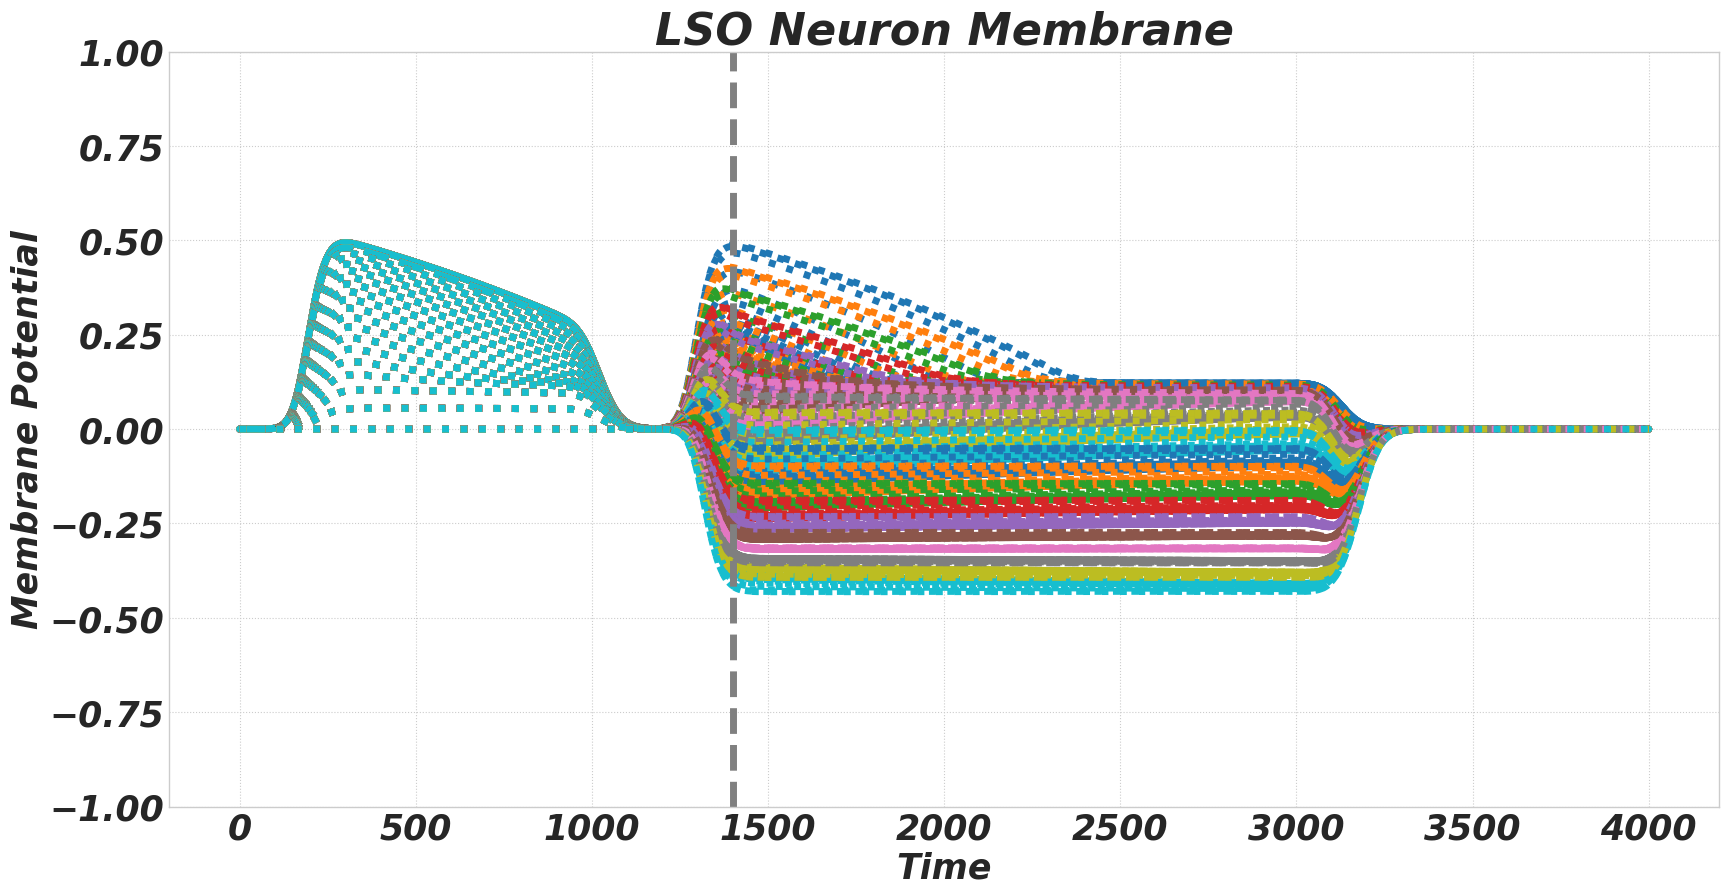

In [60]:
# Define the times when to probe
probing_times = [1400]
# show LSO neuron membrane
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure()
ax2 = fig.add_subplot(111)
for j in range(0,len(adaptor_tone)):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(r[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

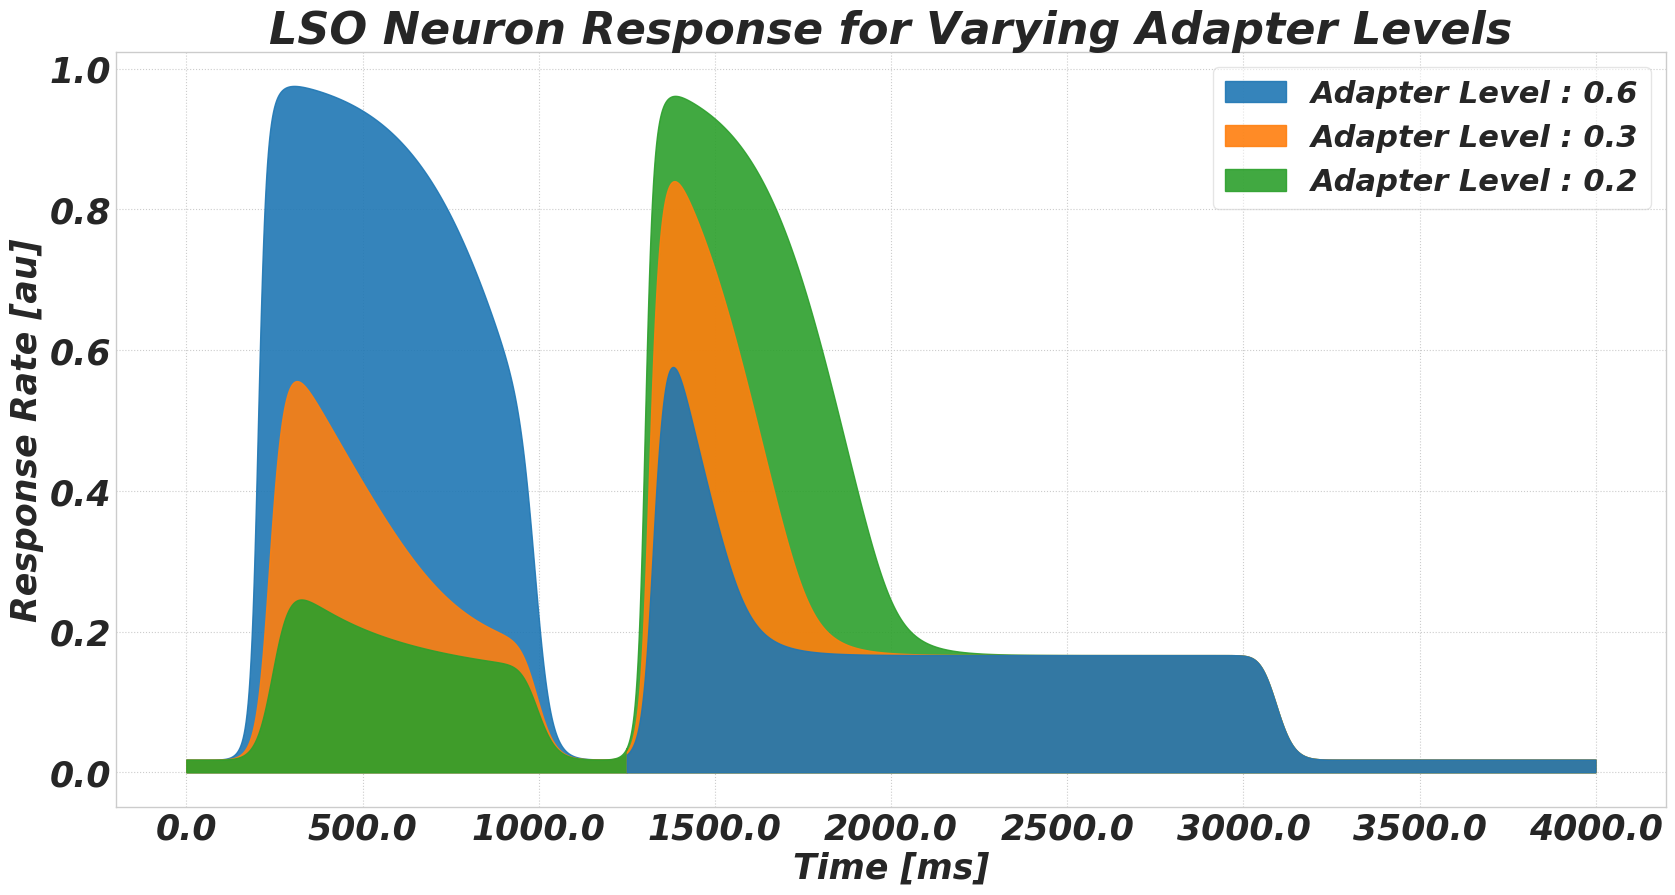

In [51]:

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()


plotting_range = np.arange(0,1250)
## show LSO neuron response
ax2 = fig.add_subplot(111)
l = 0
adaptor_levels = [7,int(r.shape[0]/2)+4,r.shape[0]-4]
# adaptor_levels = range(0,r.shape[0])
for j in adaptor_levels:
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    l +=1
    for i in range(1,2):
        tmp = g_r_out(r[j,i,:])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
        ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color, alpha=0.9,label='Adapter Level : {0:.1f}'.format(adaptor_tone[j]))


plotting_range = np.arange(1250,4000)
## show LSO neuron response
for j in adaptor_levels[::-1]:
    l -=1
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'



    for i in range(1,2):
        tmp = g_r_out(r[j,i,:])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color)
        ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color,  alpha=0.9)
        
        
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.ylabel('Response Rate [au]')
plt.xlabel('Time [ms]')
ax2.set_xticklabels(ax2.get_xticks())
ax2.invert_xaxis()
lgd = plt.legend()

plt.savefig(figure_name + 'membrane_adapter.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_adapter.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




The ratio between the inhibitory feedback on the excitatory and the inhibitory feedback on the inhibitory input is a crucial here since it determines the sensitivity of the neuron for tones succeeding an adaptor tone. If the we have a high ratio, say the GABA_exc is two times higher than the GABA_inh, then the difference of level for the succeeding tone is smaller then for for higher ratios e.g. a ratio of GABA_exc = GABA_inh * 3.5 creates a larger difference in succeeding sounds. This behavior leads to a bigger shift of ILD values towards the more/most sensitive range. Psychophysics expiriments would need to be conducte to see the adaptation value and thereby the ratio between the inhibitory feedback on the excitatory and the inhibitory feedback on the inhibitory input.

Maybe we plot value for different ratios...

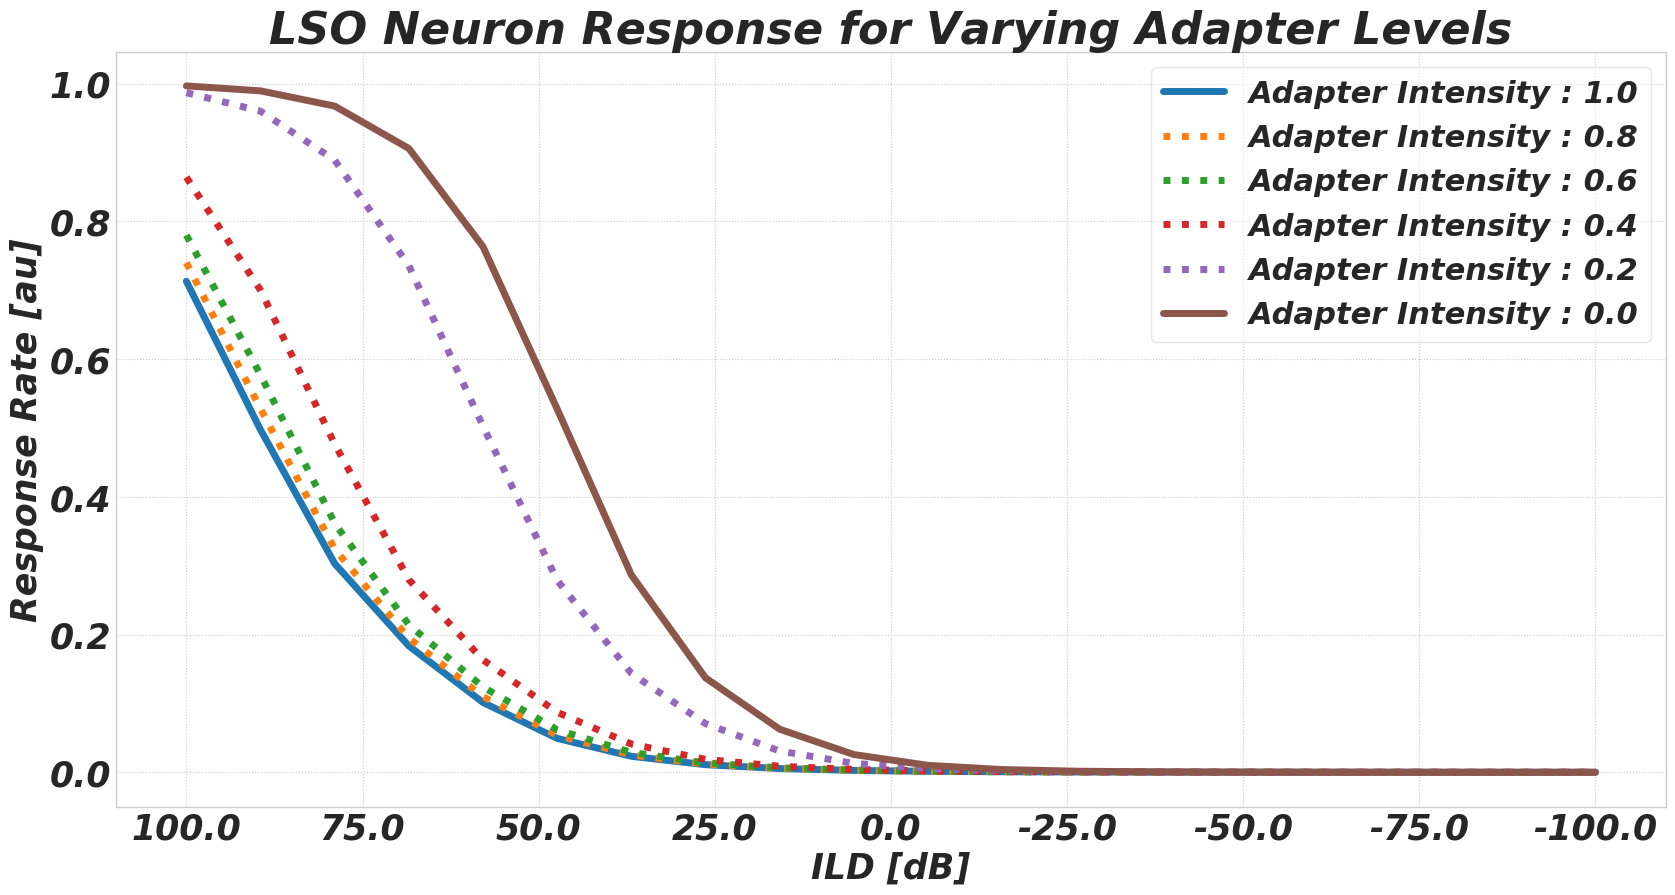

In [61]:
# Define the times when to probe
# probing_times = [1400]
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for j in np.concatenate([np.arange(0,len(adaptor_tone),4),[len(adaptor_tone)-1]]):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
        diff = gbc_input_intensities-sbc_input_intensities
        ax2.plot(-diff,tmp,linestyle=line_style,label='Adapter Intensity : {0:.1f}'.format(adaptor_tone[j]))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




In [1]:

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)

ilds = np.zeros((r.shape[1],len(adaptor_tone)))
for j in np.concatenate([np.arange(0,len(adaptor_tone),4),[len(adaptor_tone)-1]]):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
        ilds[j,:] = tmp
                
ax2.plot(diff[:-1],-np.diff(ilds).T)
# plt.plot(ilds.T)
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

plt.title('Suppose to be the Standard Separation D (Dahmen et. al ). Needs to be confirmed')
plt.show()

NameError: name 'plt' is not defined

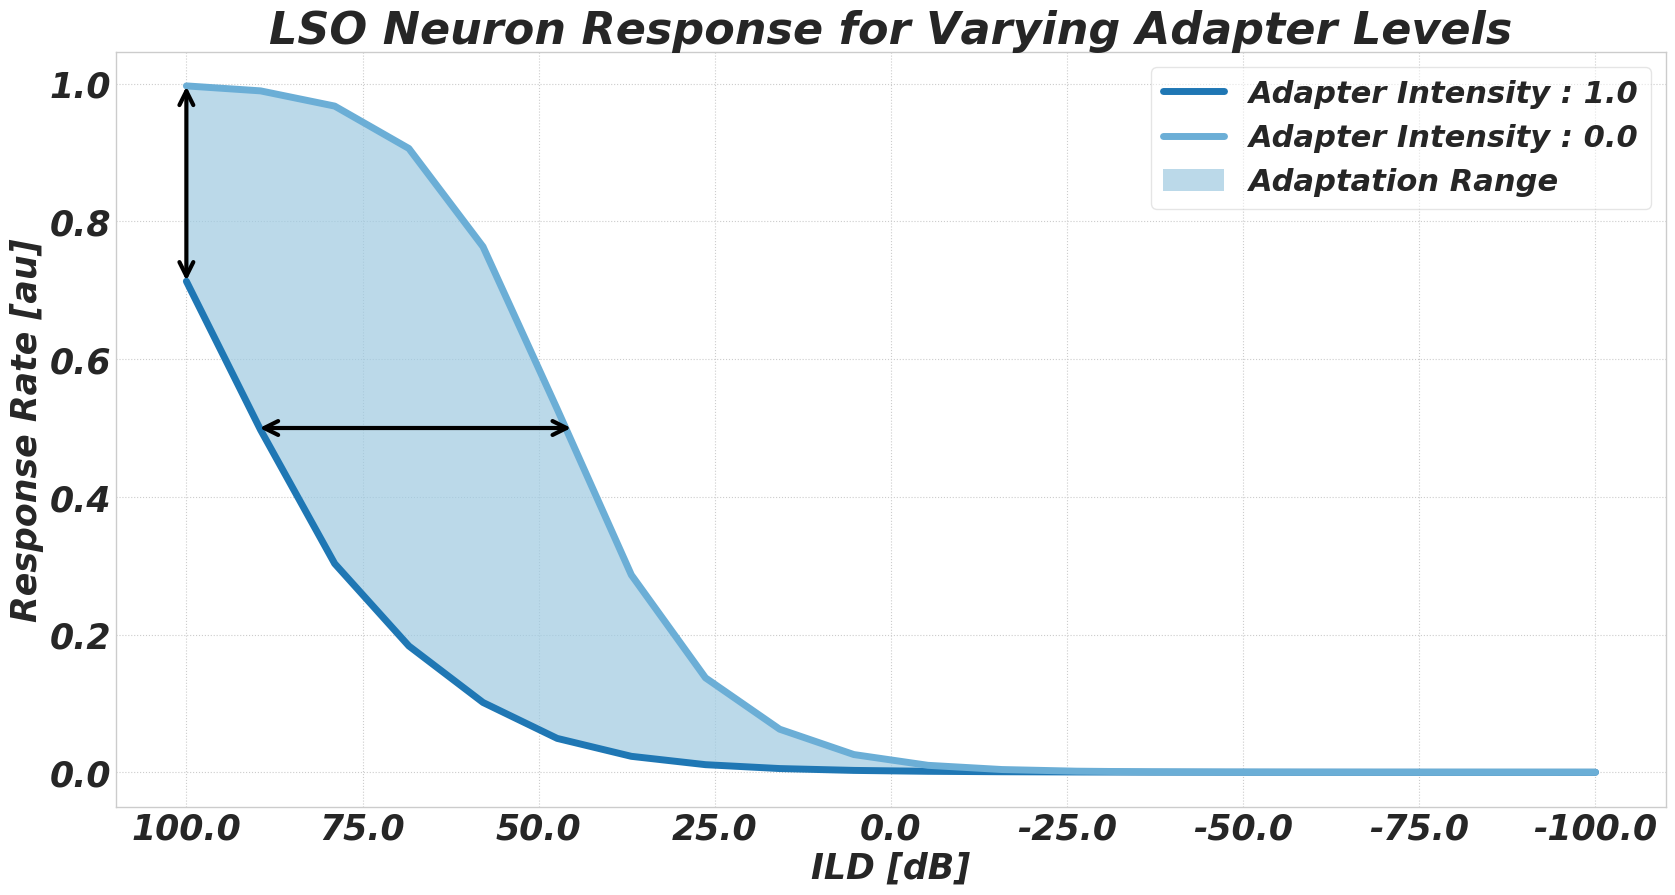

In [49]:
# Define the times when to probe
# probing_times = [1400]

fig = plt.figure()


diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

## show LSO neuron response
ax2 = fig.add_subplot(111)
probing = probing_times[0]

tmp = g_r_out(r[0,:,probing])
ax2.plot(-diff,tmp,linestyle='-',label='Adapter Intensity : {0:.1f}'.format(adaptor_tone[0]))

tmp2 = g_r_out(r[-1,:,probing])
ax2.plot(-diff,tmp2,linestyle='-',color='#6baed6',label='Adapter Intensity : {0:.1f}'.format(adaptor_tone[-1]))

ax2.fill_between(-diff,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

ax2.annotate("", xy=(0.90, 0.5), xytext=(0.45, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))

ax2.annotate("", xy=(1, 1), xytext=(1, 0.71),arrowprops=dict(arrowstyle="<->",linewidth=3))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()


